<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2D_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Centre bias attention model

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Define Model with Attention Layers

In [24]:
img_size_div4 = 45  # Image size

class CenterBiasAttentionLayer(nn.Module):
    def __init__(self, img_size, in_channels):
        super(CenterBiasAttentionLayer, self).__init__()
        self.img_size = img_size
        self.in_channels = in_channels

        y, x = torch.meshgrid(torch.linspace(-1, 1, img_size), torch.linspace(-1, 1, img_size)) # Create a static center bias mask
        self.register_buffer("center_bias", torch.exp(-(x**2 + y**2) / 0.3))  # Gaussian

    def forward(self, x):
        b, c, h, w = x.size()
        resized_bias = F.interpolate(self.center_bias[None, None, :, :], size=(h, w), mode='bilinear', align_corners=True)
        attention_mask = resized_bias.repeat(b, c, 1, 1)  # Repeat for batch and channels

        return x * attention_mask

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.center_bias = CenterBiasAttentionLayer(img_size, 3)  # Center bias applied to the input image
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * img_size_div4 * img_size_div4, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x, attn_on=True):
        x = self.center_bias(x)  # Apply center bias directly to the input
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 16 * img_size_div4 * img_size_div4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Load and Edit Data

In [20]:
img_size = img_size_div4 * 4 # Define image size

train_transform = transforms.Compose([ # Define transformations for training
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=4),   # Randomly rotate images by up to 15 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([ # Define transformations for testing (no augmentation)
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define paths to your train and test directories
train_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/train'
test_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/test'

batch_size = 20
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) # Load datasets using ImageFolder
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train the Model

In [25]:
lr = 0.0006 # Learning rate
num_epochs = 20 # Number of epochs for training

model = CNN() # Initialise a model
criterion = nn.CrossEntropyLoss()  # Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
t = time.time() # Start timer
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader: # Loop through images and labels to train
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    time_elapsed = time.time() - t # Calculate time elapsed
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {time_elapsed}")


KeyboardInterrupt: 

### Testing the Model

In [22]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5088


### Visualise a Centre Bias Mask

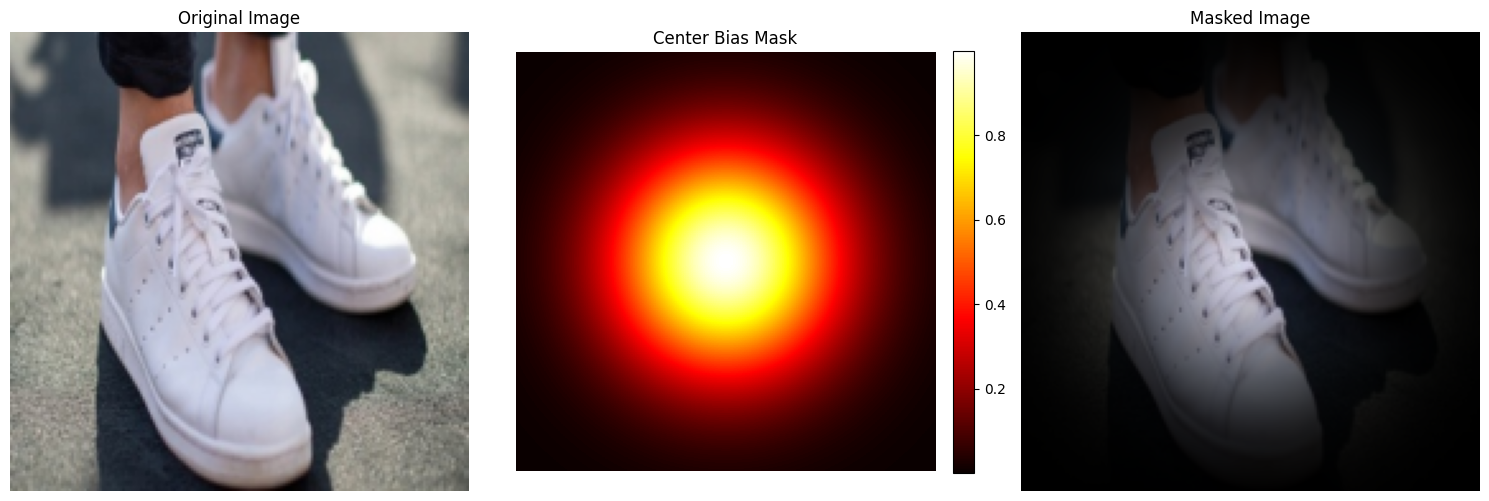

In [26]:


def denormalise(img, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    denormalised_img = img * std + mean
    return denormalised_img

def visualize_cba_on_image(model, sample_image, mean, std):
    denormalised_image = denormalise(sample_image, mean, std)
    denormalised_image = denormalised_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    denormalised_image = np.clip(denormalised_image, 0, 1)

    center_bias_mask = model.center_bias.center_bias.cpu().numpy().squeeze()

    # Resize the centre bias mask to match the image dimensions
    h, w = sample_image.shape[2:]
    resized_mask = torch.nn.functional.interpolate(
        torch.tensor(center_bias_mask).unsqueeze(0).unsqueeze(0),
        size=(h, w),
        mode='bilinear',
        align_corners=True
    ).squeeze().numpy()

    masked_image = denormalised_image * resized_mask[..., np.newaxis]


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(denormalised_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    im = axes[1].imshow(resized_mask, cmap="hot")
    axes[1].set_title("Center Bias Mask")
    axes[1].axis("off")
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    axes[2].imshow(masked_image)
    axes[2].set_title("Masked Image")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Assume 'model' is your CNN and 'sample_image' is a single image tensor (1, 3, H, W)
sample_image = next(iter(test_loader))[0][0].unsqueeze(0)  # Extract a sample image from the loader

visualize_cba_on_image(model, sample_image, mean, std)
